# Predicting Red Wine Quality, Part 2
Data from http://archive.ics.uci.edu/ml/datasets/Wine+Quality

## Citations
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

Available at:
- [@Elsevier](http://dx.doi.org/10.1016/j.dss.2009.05.016)
- [Pre-press (pdf)](http://www3.dsi.uminho.pt/pcortez/winequality09.pdf)
- [bib](http://www3.dsi.uminho.pt/pcortez/dss09.bib)

Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
red_wine = pd.read_csv('data/winequality-red.csv')
red_wine['high_quality'] = pd.cut(red_wine.quality, bins=[0, 6, 10], labels=[0, 1])

Since we completed our EDA in the [red_wine.ipynb notebook for last chapter](https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/blob/master/ch_09/red_wine.ipynb), we will just look at the first 5 rows to refresh our memory of the data rather than repeating the EDA here.

In [3]:
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,high_quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


## Train Test Split

In [4]:
from sklearn.model_selection import train_test_split

red_y = red_wine.pop('high_quality')
red_X = red_wine.drop(columns='quality')

r_X_train, r_X_test, \
r_y_train, r_y_test = train_test_split(
    red_X, red_y, test_size=0.1, random_state=0, 
    stratify=red_y
)

## Searching for the Best Hyperparameters with Plots
We have been working with training and testing sets; however, in order to try out different hyperparameters, we need a third set: the validation set. We will train with the training set as usual. The validation set will be used to test different hyperparameters. Only after we have our model tuned will we test with the testing set. Note that the validation set is not the testing set, nor should they contain the same data. 

One way of making the validation set would be to run `train_test_split()` on the training data:

In [5]:
from sklearn.model_selection import train_test_split

r_X_train_new, r_X_validate, r_y_train_new, r_y_validate = train_test_split(
    r_X_train, r_y_train, test_size=0.3, random_state=0, stratify=r_y_train
)

`C` is the regularization parameter. It determines the weight on the penalty term. We will try 10 values from 10^-1 to 10^1 for `C`. To make this range of numbers, we use `np.logspace()` and provide the exponents (-1 and 1) of the minimum and maximum values in the range. We then get evenly-spaced values in between:

Text(0.5, 1.0, 'F1 Score vs. Regularization Strength')

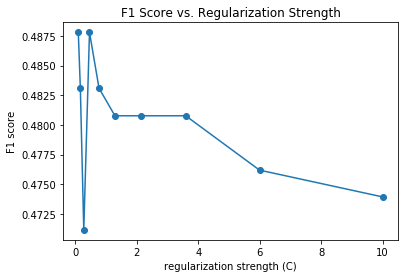

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

regularization_strengths = np.logspace(-1, 1, num=10)
scores = []

for regularization_strength in regularization_strengths:
    pipeline = Pipeline([
        ('scale', MinMaxScaler()),
        ('lr', LogisticRegression(
            solver='lbfgs', class_weight='balanced',
            random_state=0, C=regularization_strength
        ))
    ]).fit(r_X_train_new, r_y_train_new)
    scores.append(f1_score(pipeline.predict(r_X_validate), r_y_validate))

plt.plot(regularization_strengths, scores,'o-')
plt.xlabel('regularization strength (C)')
plt.ylabel('F1 score')
plt.title('F1 Score vs. Regularization Strength')

## Searching for Best Hyperparameters with `GridSearchCV`
We can specify a search space as a dictionary of parameter names and values to try for each. Note that if we have any preprocessing steps, we must use a pipeline. We can tune hyperparameters in a pipeline if we prefix the hyperparameter name with the step's name followed by `__`. We can specify the metric to use for the tuning as well:

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
    ('scale', MinMaxScaler()),
    ('lr', LogisticRegression(
        solver='lbfgs', class_weight='balanced', random_state=0
    ))
])

search_space = {
    'lr__C': np.logspace(-1, 1, num=10), # regularization strength
    'lr__fit_intercept' : [True, False]
}
lr_grid = GridSearchCV(pipeline, search_space, scoring='f1_macro', cv=5).fit(r_X_train, r_y_train)

We can use the `best_params_` attribute to see the best parameters from the grid search:

In [8]:
lr_grid.best_params_

{'lr__C': 3.593813663804626, 'lr__fit_intercept': True}

The `best_score_` shows the score for the specified metric that was achieved on the validation set using the best parameters:

In [9]:
lr_grid.best_score_

0.6854820202971804

By using the testing set, we can see that our F1 score is now higher than what we got without hyperparameter tuning in [chapter 9](https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/blob/master/ch_09/red_wine.ipynb):

In [10]:
from sklearn.metrics import classification_report
print(classification_report(r_y_test, lr_grid.predict(r_X_test)))

              precision    recall  f1-score   support

           0       0.94      0.80      0.87       138
           1       0.36      0.68      0.47        22

   micro avg       0.79      0.79      0.79       160
   macro avg       0.65      0.74      0.67       160
weighted avg       0.86      0.79      0.81       160



### `GridSearchCV` with CV Object
We can specify the number of folds to use for cross validation and even change the method of doing so with the `cv` parameter:

In [11]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

lr_grid = GridSearchCV(
    pipeline, search_space, scoring='f1_macro',
    cv=RepeatedStratifiedKFold(random_state=0)
).fit(r_X_train, r_y_train)

Note that this is different from before:

In [12]:
print('Best parameters (CV score=%.2f): %s' % (
    lr_grid.best_score_, lr_grid.best_params_
))

Best parameters (CV score=0.69): {'lr__C': 5.994842503189409, 'lr__fit_intercept': True}


## Polynomial features and interaction terms
We can look at a pairplot to try and find any non-linear relationships between the features in our model:

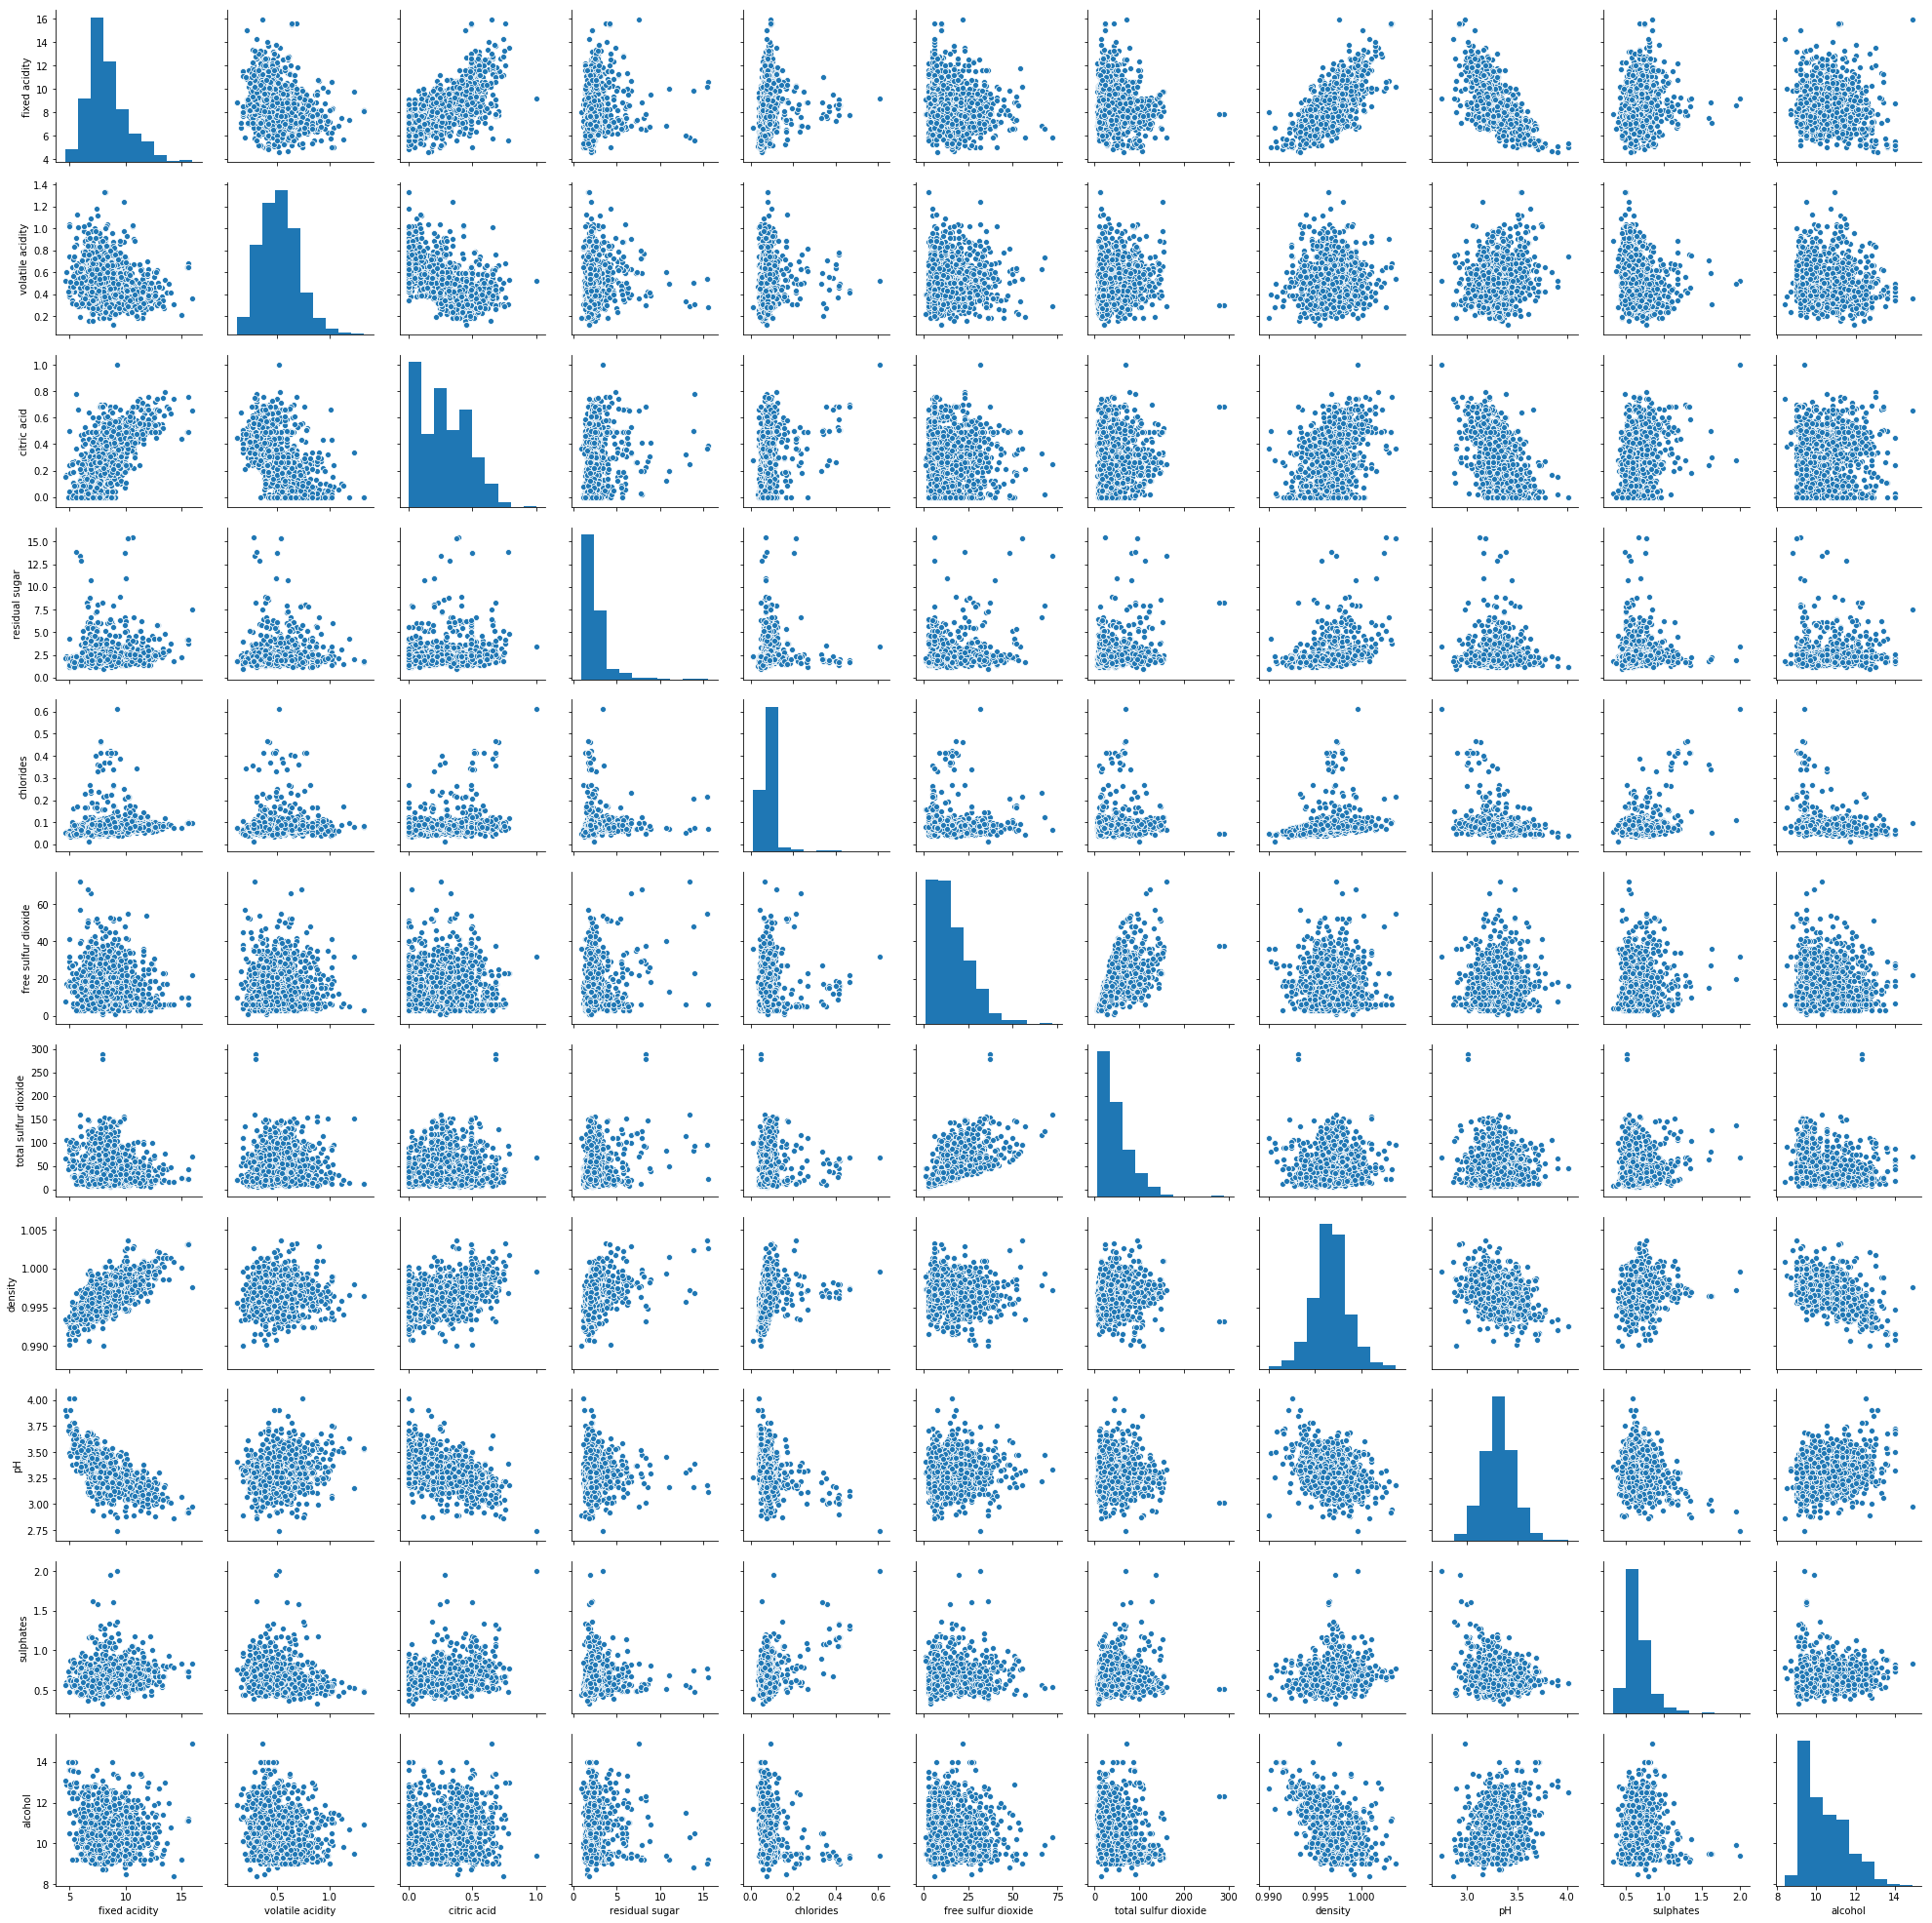

In [13]:
sns.pairplot(r_X_train)

If we suspect there is a non-linear relationship between our variables, we can add polynomial features to our model to generalize our linear model. The `PolynomialFeatures` class from scikit-learn will transform our input data into the a bias term (1), a term for each of the variables as found in the starting data, a term for each combination of 2 variables multiplied together, and the square of each variable (this can be modified to include higher powers with the `degree` parameter):

In [14]:
from sklearn.preprocessing import PolynomialFeatures

PolynomialFeatures().fit_transform(r_X_train[['citric acid', 'fixed acidity']])

array([[1.000e+00, 5.500e-01, 9.900e+00, 3.025e-01, 5.445e+00, 9.801e+01],
       [1.000e+00, 4.600e-01, 7.400e+00, 2.116e-01, 3.404e+00, 5.476e+01],
       [1.000e+00, 4.100e-01, 8.900e+00, 1.681e-01, 3.649e+00, 7.921e+01],
       ...,
       [1.000e+00, 1.200e-01, 7.000e+00, 1.440e-02, 8.400e-01, 4.900e+01],
       [1.000e+00, 3.100e-01, 7.600e+00, 9.610e-02, 2.356e+00, 5.776e+01],
       [1.000e+00, 2.600e-01, 7.700e+00, 6.760e-02, 2.002e+00, 5.929e+01]])

Note we can also specify to not include the bias (`include_bias=False`) and to only give interaction terms (`interaction_only=True`). This leaves us with the value for each of the variables and their interaction term:

In [15]:
from sklearn.preprocessing import PolynomialFeatures

PolynomialFeatures(
    include_bias=False, interaction_only=True
).fit_transform(r_X_train[['citric acid', 'fixed acidity']])

array([[0.55 , 9.9  , 5.445],
       [0.46 , 7.4  , 3.404],
       [0.41 , 8.9  , 3.649],
       ...,
       [0.12 , 7.   , 0.84 ],
       [0.31 , 7.6  , 2.356],
       [0.26 , 7.7  , 2.002]])

We can put this in a pipeline to build our model with these features:

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scale', MinMaxScaler()),
    ('lr', LogisticRegression(
        solver='lbfgs', class_weight='balanced', random_state=0
    ))
]).fit(r_X_train, r_y_train)

Notice the performance is slightly better than it was before:

In [17]:
from sklearn.metrics import classification_report

preds = pipeline.predict(r_X_test)
print(classification_report(r_y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       138
           1       0.36      0.73      0.48        22

   micro avg       0.78      0.78      0.78       160
   macro avg       0.65      0.76      0.67       160
weighted avg       0.87      0.78      0.81       160



## Feature Unions
We can combine multiple preprocessing transformations on our data with the feature union:

In [18]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression

combined_features = FeatureUnion([
    ('variance', VarianceThreshold(0.01)),
    ('poly', PolynomialFeatures(include_bias=False, interaction_only=True))
])

pipeline = Pipeline([
    ('normalize', MinMaxScaler()),
    ('feature_union', combined_features),
    ('lr', LogisticRegression(
        solver='lbfgs', class_weight='balanced', random_state=0
    ))
]).fit(r_X_train, r_y_train)

See the feature union (first 9 are from `VarianceThreshold`, rest are interaction terms):

In [19]:
pipeline.named_steps['feature_union'].transform(r_X_train)[0]

array([9.900000e+00, 3.500000e-01, 5.500000e-01, 5.000000e+00,
       1.400000e+01, 9.971000e-01, 3.260000e+00, 1.060000e+01,
       9.900000e+00, 3.500000e-01, 5.500000e-01, 2.100000e+00,
       6.200000e-02, 5.000000e+00, 1.400000e+01, 9.971000e-01,
       3.260000e+00, 7.900000e-01, 1.060000e+01, 3.465000e+00,
       5.445000e+00, 2.079000e+01, 6.138000e-01, 4.950000e+01,
       1.386000e+02, 9.871290e+00, 3.227400e+01, 7.821000e+00,
       1.049400e+02, 1.925000e-01, 7.350000e-01, 2.170000e-02,
       1.750000e+00, 4.900000e+00, 3.489850e-01, 1.141000e+00,
       2.765000e-01, 3.710000e+00, 1.155000e+00, 3.410000e-02,
       2.750000e+00, 7.700000e+00, 5.484050e-01, 1.793000e+00,
       4.345000e-01, 5.830000e+00, 1.302000e-01, 1.050000e+01,
       2.940000e+01, 2.093910e+00, 6.846000e+00, 1.659000e+00,
       2.226000e+01, 3.100000e-01, 8.680000e-01, 6.182020e-02,
       2.021200e-01, 4.898000e-02, 6.572000e-01, 7.000000e+01,
       4.985500e+00, 1.630000e+01, 3.950000e+00, 5.3000

This also results in marginal improvements in recall in F1 score:

In [20]:
from sklearn.metrics import classification_report

preds = pipeline.predict(r_X_test)
print(classification_report(r_y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.80      0.87       138
           1       0.36      0.68      0.47        22

   micro avg       0.79      0.79      0.79       160
   macro avg       0.65      0.74      0.67       160
weighted avg       0.86      0.79      0.81       160



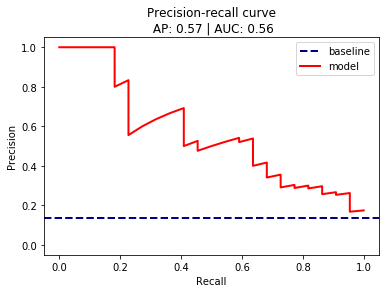

In [21]:
from ml_utils.classification import plot_pr_curve
plot_pr_curve(r_y_test, pipeline.predict_proba(r_X_test)[:,1])

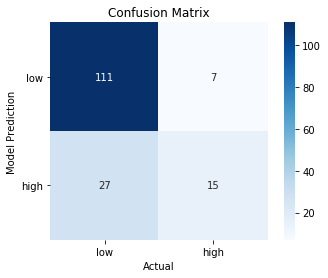

In [22]:
from ml_utils.classification import confusion_matrix_visual
confusion_matrix_visual(r_y_test, preds, ['low', 'high'])

## Ensemble methods
Ensemble methods combine many models (often weak ones) to create another (stronger one) that will either minimize average error between actual and predicted (the bias) or improve how well it generalizes to unseen data (minimize the variance). We have to strike a balance between complex models that may increase variance, as they tend to overfit, with simple models that may have high bias, as they tend to underfit. This is called the bias-variance tradeoff, which is illustrated in the following subplots:

Text(0.5, 1.0, 'balance')

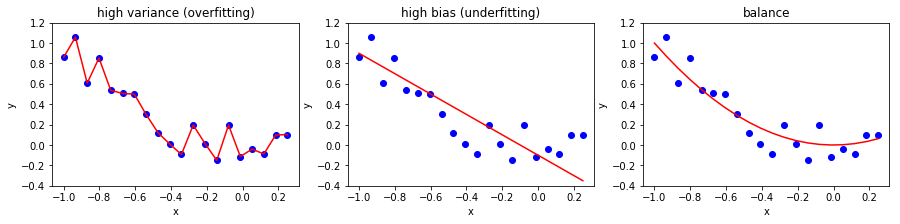

In [23]:
np.random.seed(5)
x = np.linspace(start=-1, stop=0.25, num=20)
y = x**2 + np.random.uniform(-0.25, 0.25, size=20)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

for ax in axes:
    ax.plot(x, y, 'bo')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_ylim(-0.4, 1.2)

axes[0].plot(x, y, 'r-')
axes[0].set_title('high variance (overfitting)')

axes[1].plot(x, x * -1 - 0.1, 'r-')
axes[1].set_title('high bias (underfitting)')

axes[2].plot(x, x**2, 'r-')
axes[2].set_title('balance')

### Ensemble Method: Random Forest
A random forest is a bagging technique (bootstrap aggregating), where we build many decision trees that each get a different bootstrapped sample of the data. At the end, this is aggregated by voting for classification and averaging for regression:

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators=100, random_state=0)

search_space = {
    'max_depth' : [4, 8],
    'min_samples_leaf' : [4, 6]
}

rf_grid = GridSearchCV(
    rf, search_space, cv=5, scoring='precision'
).fit(r_X_train, r_y_train)

rf_preds = rf_grid.predict(r_X_test)
rf_grid.score(r_X_test, r_y_test)

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6

### Ensemble Method: Gradient Boosted Trees
This is a boosting technique, meaning many weak learners are trained, but each learns from the mistakes of the others:

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

gb = GradientBoostingClassifier(n_estimators=100, random_state=0)
search_space = {
    'max_depth' : [4, 8],
    'min_samples_leaf' : [4, 6],
    'learning_rate' : [0.1, 0.5, 1]
}

gb_grid = GridSearchCV(
    gb, search_space, cv=5, scoring='f1_macro'
).fit(r_X_train, r_y_train)

gb_preds = gb_grid.predict(r_X_test)
gb_grid.score(r_X_test, r_y_test)

0.7226024272287617

### Voting
We can combine various models with voting. Often it will be interesting to first check their level of agreement with Cohen's Kappa score. Let's check the agreement between the gradient boosting classifier and the random forest range is [-1, 1]:

In [26]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(
    rf_grid.predict(r_X_test), gb_grid.predict(r_X_test)
)

0.7185929648241206

There are two ways to conduct voting:
- majority rules (hard)
- highest probability (soft)

In [27]:
from sklearn.ensemble import VotingClassifier

majority_rules = VotingClassifier(
    [('lr', lr_grid.best_estimator_), ('rf', rf_grid.best_estimator_), ('gb', gb_grid.best_estimator_)],
    voting='hard'
).fit(r_X_train, r_y_train)

max_probabilities = VotingClassifier(
    [('lr', lr_grid.best_estimator_), ('rf', rf_grid.best_estimator_), ('gb', gb_grid.best_estimator_)],
    voting='soft'
).fit(r_X_train, r_y_train)

Agreement between majority rules and max probabilities:

In [28]:
cohen_kappa_score(
    majority_rules.predict(r_X_test), max_probabilities.predict(r_X_test)
)

0.8807305255311219

#### Majority Rules Evaluation

In [29]:
majority_rules_preds = majority_rules.predict(r_X_test)

This is our best model yet:

In [30]:
from sklearn.metrics import classification_report
print(classification_report(r_y_test, majority_rules_preds))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       138
           1       0.59      0.45      0.51        22

   micro avg       0.88      0.88      0.88       160
   macro avg       0.75      0.70      0.72       160
weighted avg       0.87      0.88      0.87       160



#### Max Probabilities Evaluation

In [31]:
max_prob_preds = max_probabilities.predict(r_X_test)

This performs worse than the majority rules voting:

In [32]:
from sklearn.metrics import classification_report
print(classification_report(r_y_test, max_prob_preds))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       138
           1       0.52      0.50      0.51        22

   micro avg       0.87      0.87      0.87       160
   macro avg       0.72      0.71      0.72       160
weighted avg       0.87      0.87      0.87       160



## Class Imbalances
KNN for baseline

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors=5
).fit(r_X_train, r_y_train)

knn_preds = knn.predict(r_X_test)

Check the performance of the baseline for reference later:

In [34]:
from sklearn.metrics import classification_report
print(classification_report(r_y_test, knn_preds))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       138
           1       0.50      0.41      0.45        22

   micro avg       0.86      0.86      0.86       160
   macro avg       0.70      0.67      0.69       160
weighted avg       0.85      0.86      0.86       160



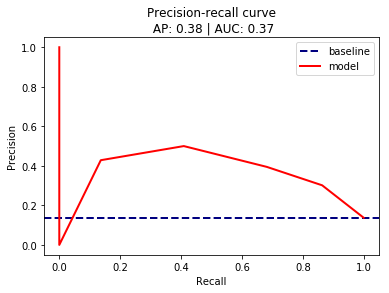

In [35]:
from ml_utils.classification import plot_pr_curve
plot_pr_curve(r_y_test, knn.predict_proba(r_X_test)[:,1])

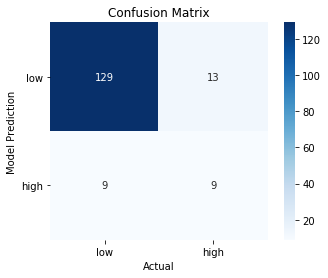

In [36]:
from ml_utils.classification import confusion_matrix_visual
confusion_matrix_visual(r_y_test, knn_preds, ['low', 'high'])

### Random under-sampling
We will under-sample the majority class, which will reduce the amount of training data available:

In [37]:
from imblearn.under_sampling import RandomUnderSampler

X_train_undersampled, y_train_undersampled = RandomUnderSampler(
    random_state=0
).fit_resample(r_X_train, r_y_train)

Notice how few observations we have in the minority class:

In [38]:
r_y_train.value_counts() # before

0    1244
1     195
Name: high_quality, dtype: int64

That is now the number of observations in the majority class. We lost over 50% of the data:

In [39]:
pd.Series(y_train_undersampled).value_counts().sort_index() # after

0    195
1    195
dtype: int64

Fitting the model is the same as before:

In [40]:
from sklearn.neighbors import KNeighborsClassifier

knn_undersampled = KNeighborsClassifier(
    n_neighbors=5
).fit(X_train_undersampled, y_train_undersampled)

knn_undersampled_preds = knn_undersampled.predict(r_X_test)

Due to the lack of available data, this model is worse than before:

In [41]:
from sklearn.metrics import classification_report
print(classification_report(r_y_test, knn_undersampled_preds))

              precision    recall  f1-score   support

           0       0.93      0.65      0.77       138
           1       0.24      0.68      0.35        22

   micro avg       0.66      0.66      0.66       160
   macro avg       0.58      0.67      0.56       160
weighted avg       0.83      0.66      0.71       160



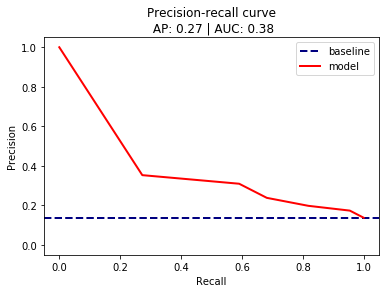

In [42]:
from ml_utils.classification import plot_pr_curve
plot_pr_curve(r_y_test, knn_undersampled.predict_proba(r_X_test)[:,1])

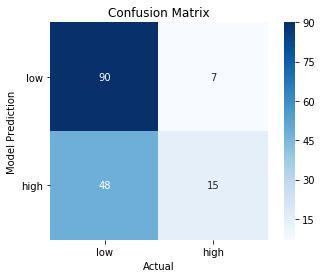

In [43]:
from ml_utils.classification import confusion_matrix_visual
confusion_matrix_visual(r_y_test, knn_undersampled_preds, ['low', 'high'])

### Over-sampling with [SMOTE](https://arxiv.org/pdf/1106.1813.pdf)
This technique will make synthetic data, so it's important to if it is a reasonable assumption to make that the data we have is representative of the full spectrum we will see and whether it will change over time:

In [44]:
from imblearn.over_sampling import SMOTE

X_train_oversampled, y_train_oversampled = SMOTE(
    random_state=0
).fit_resample(r_X_train, r_y_train)

Before, the imbalance could be observed in the training set:

In [45]:
r_y_train.value_counts() # before

0    1244
1     195
Name: high_quality, dtype: int64

Now, both classes have the same number of observations:

In [46]:
pd.Series(y_train_oversampled).value_counts().sort_index() # after

0    1244
1    1244
dtype: int64

Building the model with the oversampled data is the same as before:

In [47]:
from sklearn.neighbors import KNeighborsClassifier

knn_oversampled = KNeighborsClassifier(
    n_neighbors=5
).fit(X_train_oversampled, y_train_oversampled)

knn_oversampled_preds = knn_oversampled.predict(r_X_test)

This model has higher recall than the class imbalance k-NN model:

In [48]:
from sklearn.metrics import classification_report
print(classification_report(r_y_test, knn_oversampled_preds))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86       138
           1       0.37      0.82      0.51        22

   micro avg       0.78      0.78      0.78       160
   macro avg       0.67      0.80      0.68       160
weighted avg       0.88      0.78      0.81       160



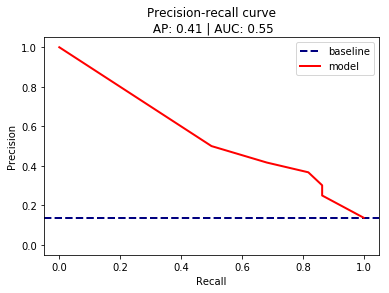

In [49]:
from ml_utils.classification import plot_pr_curve
plot_pr_curve(r_y_test, knn_oversampled.predict_proba(r_X_test)[:,1])

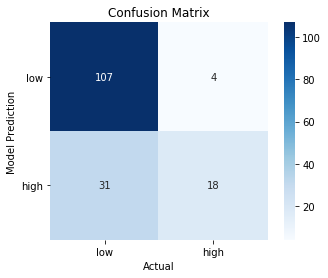

In [50]:
from ml_utils.classification import confusion_matrix_visual
confusion_matrix_visual(r_y_test, knn_oversampled_preds, ['low', 'high'])